In [1]:
import rasterio
import os
import numpy as np
from sklearn.model_selection import train_test_split
from rasterio.plot import show

In [2]:
# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load one file from each class
non_forest_files = [os.path.join(non_forest_dir, f) for f in os.listdir(non_forest_dir) if f.endswith('.tif')]
forest_files = [os.path.join(forest_dir, f) for f in os.listdir(forest_dir) if f.endswith('.tif')]

non_forest_example_path = non_forest_files[0]  # Example non-forest file
forest_example_path = forest_files[0]          # Example forest file

def calculate_resolution(file_path):
    with rasterio.open(file_path) as src:
        transform = src.transform
        # Calculate pixel size (resolution)
        pixel_size_x = transform[0]  # Pixel width in meters
        pixel_size_y = abs(transform[4])  # Pixel height in meters
    return pixel_size_x, pixel_size_y

# Calculate and print resolutions
non_forest_resolution = calculate_resolution(non_forest_example_path)
forest_resolution = calculate_resolution(forest_example_path)

print(f"Non-Forest Image Resolution: {non_forest_resolution[0]} meters x {non_forest_resolution[1]} meters per pixel")
print(f"Forest Image Resolution: {forest_resolution[0]} meters x {forest_resolution[1]} meters per pixel")

Non-Forest Image Resolution: 10.0 meters x 10.0 meters per pixel
Forest Image Resolution: 10.0 meters x 10.0 meters per pixel


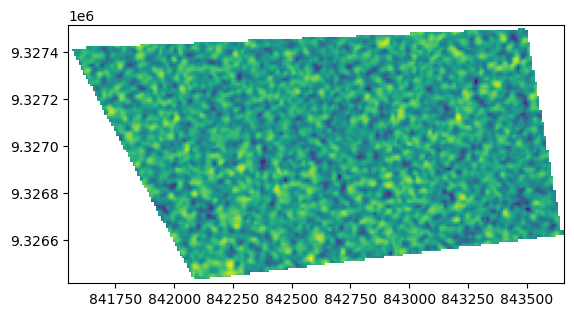

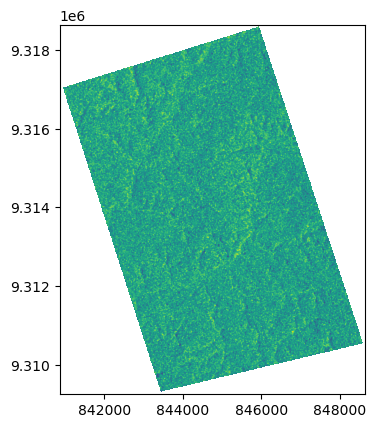

<AxesSubplot:>

In [3]:
non_forest_sardat = rasterio.open(non_forest_files[0])
show(non_forest_sardat)
forest_sardat = rasterio.open(forest_files[0])
show(forest_sardat)

In [4]:
def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the bands.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Load all non-forest and forest files
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)



In [5]:
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile.
    """
    tile_features = []
    for band in range(tile.shape[0]):
        band_data = tile[band]
        tile_features.extend([
            band_data.mean(),  # Mean
            band_data.std(),   # Standard deviation
            band_data.min(),   # Min value
            band_data.max(),   # Max value
            np.median(band_data)  # Median
        ])
    return tile_features

def tile_image(image_data, tile_size=16):
    """
    Divide an image into tiles, filtering out any tiles that contain NaN values,
    and compute statistical features for each valid tile.
    """
    h, w = image_data.shape[1], image_data.shape[2]
    tiles = []

    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tile = image_data[:, i:i+tile_size, j:j+tile_size]
            if tile.shape[1] == tile_size and tile.shape[2] == tile_size:
                if not np.isnan(tile).any():  # Ensure the tile has no NaN values
                    tile_features = extract_features_from_tile(tile)
                    tiles.append(tile_features)
    
    return np.array(tiles)

In [6]:
# Extract features using 8x8 tiles
non_forest_tiles_8 = np.vstack([tile_image(bands, tile_size=8) for bands in non_forest_data])
forest_tiles_8 = np.vstack([tile_image(bands, tile_size=8) for bands in forest_data])

# Extract features using 16x16 tiles
non_forest_tiles_16 = np.vstack([tile_image(bands, tile_size=16) for bands in non_forest_data])
forest_tiles_16 = np.vstack([tile_image(bands, tile_size=16) for bands in forest_data])

# Combine and label tiles for both tile sizes
X_8 = np.vstack([non_forest_tiles_8, forest_tiles_8])
y_8 = np.hstack([np.zeros(non_forest_tiles_8.shape[0]), np.ones(forest_tiles_8.shape[0])])

X_16 = np.vstack([non_forest_tiles_16, forest_tiles_16])
y_16 = np.hstack([np.zeros(non_forest_tiles_16.shape[0]), np.ones(forest_tiles_16.shape[0])])

print(f"8x8 Tile feature matrix shape: {X_8.shape}, Labels shape: {y_8.shape}")
print(f"16x16 Tile feature matrix shape: {X_16.shape}, Labels shape: {y_16.shape}")


8x8 Tile feature matrix shape: (316730, 15), Labels shape: (316730,)
16x16 Tile feature matrix shape: (76272, 15), Labels shape: (76272,)


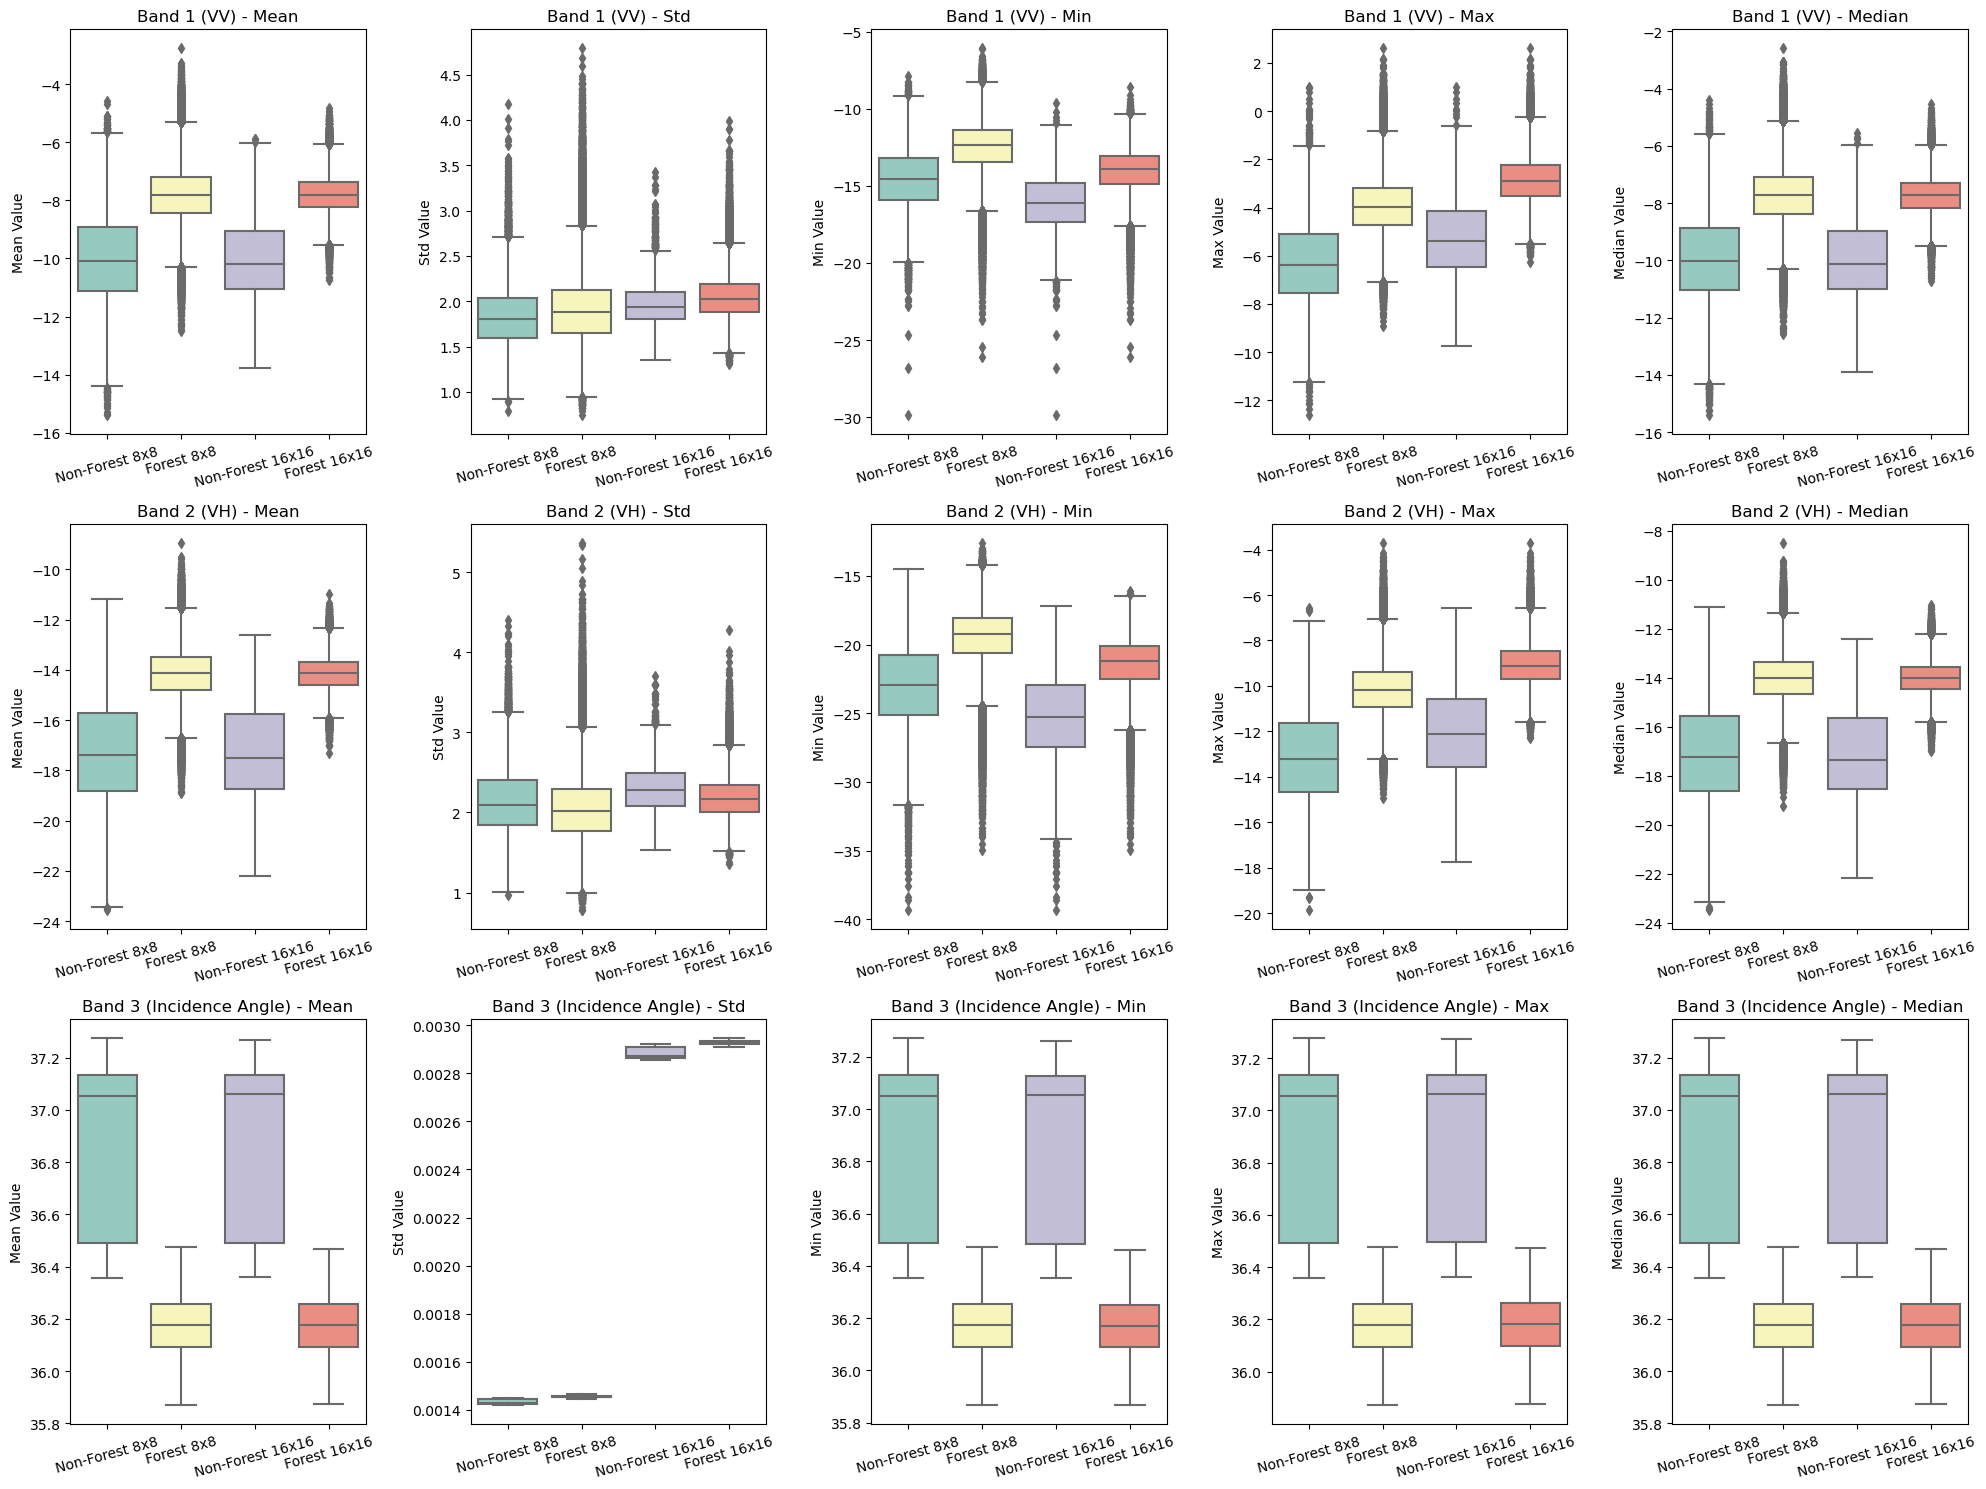

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features by class for both tile sizes
non_forest_features_8 = X_8[y_8 == 0]
forest_features_8 = X_8[y_8 == 1]
non_forest_features_16 = X_16[y_16 == 0]
forest_features_16 = X_16[y_16 == 1]

# Feature names for each band
feature_names = ['Mean', 'Std', 'Min', 'Max', 'Median']
bands = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']
n_features_per_band = 5

plt.figure(figsize=(20, 15))

# Iterate over each band and its features
for band_index, band in enumerate(bands):
    for feature_index, feature_name in enumerate(feature_names):
        feature_idx = band_index * n_features_per_band + feature_index
        
        # Create a subplot for each feature
        plt.subplot(len(bands), n_features_per_band, feature_idx + 1)
        
        # Combine the data for 8x8 and 16x16 tiles
        combined_data = [
            non_forest_features_8[:, feature_idx],
            forest_features_8[:, feature_idx],
            non_forest_features_16[:, feature_idx],
            forest_features_16[:, feature_idx]
        ]
        
        # Plot boxplot for non-forest and forest features, for both 8x8 and 16x16 tiles
        sns.boxplot(data=combined_data, palette="Set3")
        
        # Set titles and labels
        plt.title(f'{band} - {feature_name}')
        plt.xticks([0, 1, 2, 3], ['Non-Forest 8x8', 'Forest 8x8', 'Non-Forest 16x16', 'Forest 16x16'], fontsize=10, rotation=15)
        plt.ylabel(f'{feature_name} Value')
        
plt.tight_layout()
plt.show()


In [8]:
# Apply tiling and feature extraction to all non-forest and forest images
non_forest_tiles = np.vstack([tile_image(bands, tile_size=16) for bands in non_forest_data])
forest_tiles = np.vstack([tile_image(bands, tile_size=16) for bands in forest_data])

# Combine and label tiles
X = np.vstack([non_forest_tiles, forest_tiles])
y = np.hstack([np.zeros(non_forest_tiles.shape[0]), np.ones(forest_tiles.shape[0])])

print(f"Tile feature matrix shape: {X.shape}, Labels shape: {y.shape}")  ## 15 features, 5 for each band

# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Tile feature matrix shape: (76272, 15), Labels shape: (76272,)
Training set size: 53390 samples
Validation set size: 11441 samples
Test set size: 11441 samples


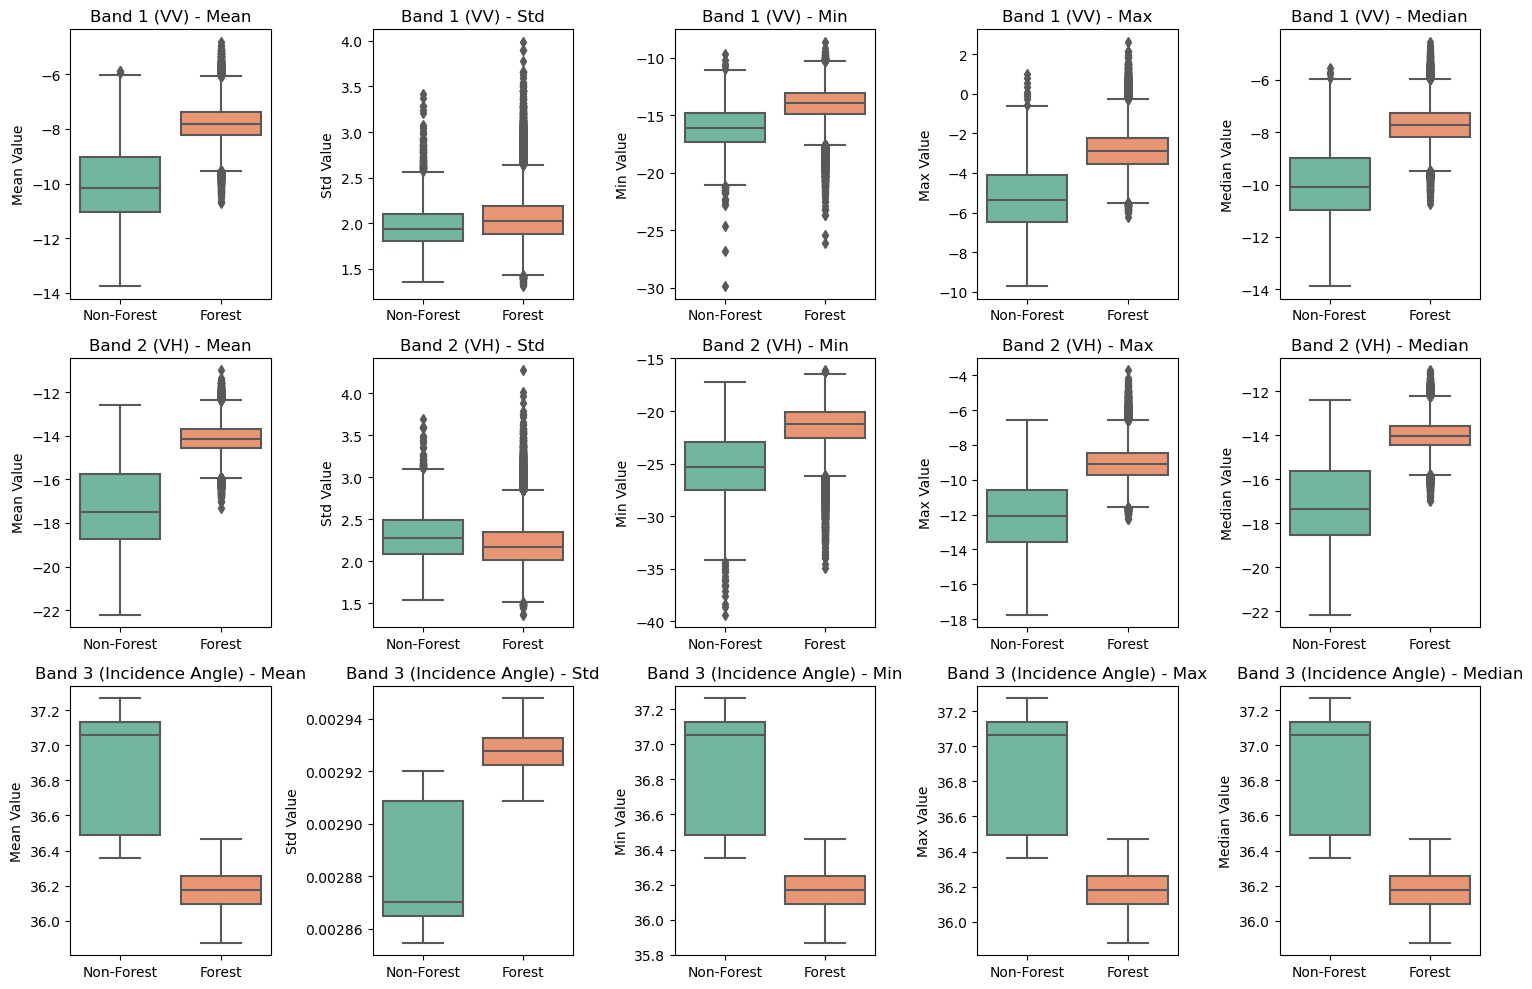

In [9]:
# Separate features by class
non_forest_features = X[y == 0]
forest_features = X[y == 1]

# Feature names for each band
feature_names = ['Mean', 'Std', 'Min', 'Max', 'Median']
bands = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 3 (Incidence Angle)']

# Number of features per band
n_features_per_band = 5

plt.figure(figsize=(15, 10))

# Iterate over each band and its features
for band_index, band in enumerate(bands):
    for feature_index, feature_name in enumerate(feature_names):
        feature_idx = band_index * n_features_per_band + feature_index
        
        # Create a subplot for each feature
        plt.subplot(len(bands), n_features_per_band, feature_idx + 1)
        
        # Plot boxplot for non-forest and forest features
        sns.boxplot(data=[non_forest_features[:, feature_idx], forest_features[:, feature_idx]], palette="Set2")
        
        # Set titles and labels
        plt.title(f'{band} - {feature_name}')
        plt.xticks([0, 1], ['Non-Forest', 'Forest'])
        plt.ylabel(f'{feature_name} Value')
        
plt.tight_layout()
plt.show()
